Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 5.2) 구매 기록 기반 상품 추천하기

### 바로가기

- [<Step1. 탐색적 분석> : UK Retail 데이터 분석하기](#<Step1.-탐색적-분석>-:-UK-Retail-데이터-분석하기)
    - [UK Retail 데이터셋의 기본 정보]
    - [탐색적 데이터 분석]
- [<Step2. 예측 분석> : SVD를 활용한 상품 구매 예측](#<Step2.-예측-분석>-:-SVD를-활용한-상품-구매-예측)
    - [피처 엔지니어링]
    - [SVD 모델 학습하기]
- [<Step3. 예측 평가하기> : 상품 추천 시뮬레이션](#<Step3.-예측-평가하기>-:-상품-추천-시뮬레이션)
    - [상품 추천 시뮬레이션]
    - [상품 추천 평가하기]

-----

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# <Step1. 탐색적 분석> : UK Retail 데이터 분석하기

### [UK Retail 데이터셋의 기본 정보]

##### 데이터 피처 설명
- InvoiceNo : 거래 고유 번호
- StockCode : 상품 고유 번호
- Description : 상품명
- Quantity : 거래 수량
- InvoiceDate : 거래 일시
- UnitPrice : 상품 단가
- CustomerID : 구매자 고유 번호
- Country : 구매 국가

-----

##### 데이터 살펴보기

In [2]:
# 영국 선물샵 온라인 도매 거래 데이터
df = pd.read_csv("../data/online_retail.csv", dtype={'CustomerID': str,'InvoiceID': str}, encoding="ISO-8859-1")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%m/%d/%Y %H:%M")

In [3]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null object
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB
None


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


-----

##### 결측 데이터 제거

In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
print(df.shape)
df = df.dropna()
print(df.shape)

(541909, 8)
(406829, 8)


-----

##### 탐색 데이터의 조건 필터링

In [6]:
# 상품수량이 음수인 경우를 제거합니다.
print(df[df['Quantity']<=0].shape[0])
df = df[df['Quantity']>0]

8905


In [7]:
# 상품 가격이 0 이하인 경우를 제거합니다.
print(df[df['UnitPrice']<=0].shape[0])
df = df[df['UnitPrice']>0]

40


In [8]:
df['StockCode']

0         85123A
1          71053
2         84406B
3         84029G
4         84029E
5          22752
6          21730
7          22633
8          22632
9          84879
10         22745
11         22748
12         22749
13         22310
14         84969
15         22623
16         22622
17         21754
18         21755
19         21777
20         48187
21         22960
22         22913
23         22912
24         22914
25         21756
26         22728
27         22727
28         22726
29         21724
           ...  
541879     22726
541880     22727
541881     16016
541882     21916
541883     84692
541884     84946
541885     21684
541886     22398
541887     23328
541888     23145
541889     22466
541890     22061
541891     23275
541892     21217
541893     20685
541894     22631
541895     22556
541896     22555
541897     22728
541898     22727
541899     22726
541900     22730
541901     22367
541902     22629
541903     23256
541904     22613
541905     22899
541906     232

In [9]:
# 상품 코드가 일반적이지 않은 경우를 탐색합니다.
df['ContainDigit'] = df['StockCode'].apply(lambda x: any(c.isdigit() for c in x)) ## stockcode에 숫자 아닌값이 있으면 False인 column
print(df[df['ContainDigit'] == False].shape[0]) #False 개수
df[df['ContainDigit'] == False].head() #False.head

1414


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ContainDigit
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583,France,False
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791,Netherlands,False
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662,Germany,False
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274,United Kingdom,False
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274,United Kingdom,False


In [10]:
# 상품 코드가 일반적이지 않은 경우를 제거합니다.
df = df[df['ContainDigit'] == True] #ContainDigit 이 False 제거

-----

### [탐색적 데이터 분석]

##### 일자별 거래 데이터 분석

In [12]:
# 거래 데이터에서 가장 오래된 데이터와 가장 최신의 데이터를 탐색합니다.
df['date'] = df['InvoiceDate'].dt.date
print(type(df['date'].min())  # date class min 가능
print(df['date'].max())

<class 'datetime.date'>
2011-12-09


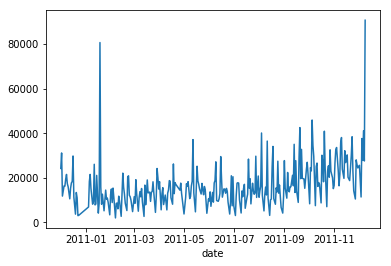

In [11]:
# 일자별 총 거래 수량을 탐색합니다.
date_quantity_series = df.groupby('date')['Quantity'].sum()
date_quantity_series.plot()

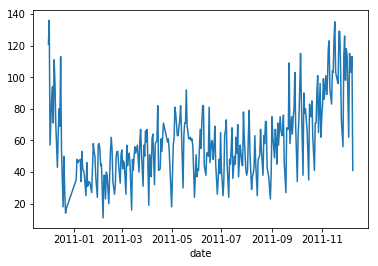

In [12]:
# 일자별 총 거래 횟수를 탐색합니다.
date_transaction_series = df.groupby('date')['InvoiceNo'].nunique()
date_transaction_series.plot()

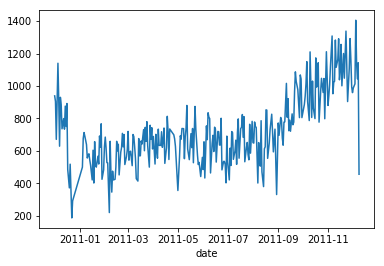

In [13]:
# 일자별 거래된 상품의 unique한 갯수, 즉 상품 거래 다양성을 탐색합니다.
date_unique_item_series = df.groupby('date')['StockCode'].nunique()
date_unique_item_series.plot()

-----

##### 유저별 구매 패턴 분석

In [14]:
# 총 유저의 수를 계산하여 출력합니다.
print(len(df['CustomerID'].unique()))

4334


In [15]:
# 유저별 거래 횟수를 탐색합니다.
customer_unique_transaction_series = df.groupby('CustomerID')['InvoiceNo'].nunique()
customer_unique_transaction_series.describe()

count    4334.000000
mean        4.246654
std         7.642535
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       206.000000
Name: InvoiceNo, dtype: float64

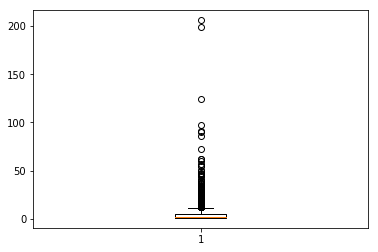

In [16]:
# 상자 그림 시각화로 살펴봅니다.
plt.boxplot(customer_unique_transaction_series.values)
plt.show()

In [17]:
# 유저별 아이템 구매 종류 개수를 탐색합니다.
customer_unique_item_series = df.groupby('CustomerID')['StockCode'].nunique()
customer_unique_item_series.describe()

count    4334.000000
mean       61.432856
std        85.312937
min         1.000000
25%        16.000000
50%        35.000000
75%        77.000000
max      1786.000000
Name: StockCode, dtype: float64

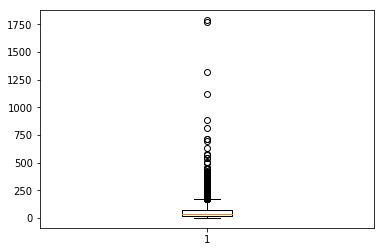

In [18]:
# 상자 그림 시각화로 살펴봅니다.
plt.boxplot(customer_unique_item_series.values)
plt.show()

-----

### `[미니 퀴즈 - 5.2]`
- `이번에는 유저가 아닌 상품을 기준으로 EDA를 실시해 보세요.` 
    - 아래의 내용들을 탐색적으로 분석해보도록 합시다.
        - 총 상품 갯수
        - 가장 거래가 많은 상품 top 10 탐색
        - 상품별 판매수량 분포 탐색
        - 거래별 가격 탐색

In [19]:
# 총 상품 갯수를 탐색합니다.
print(len(df['StockCode'].unique()))

3660


-----

In [20]:
# 가장 거래가 많은 상품 top 10 탐색
df.groupby('StockCode')['InvoiceNo'].nunique().sort_values(ascending=False)[:10]

StockCode
85123A    1978
22423     1703
85099B    1600
47566     1379
84879     1375
20725     1289
22720     1146
23203     1080
20727     1052
22383     1043
Name: InvoiceNo, dtype: int64

-----

count     3660.000000
mean      1409.149727
std       3513.654056
min          1.000000
25%         65.000000
50%        395.000000
75%       1417.500000
max      80995.000000
Name: Quantity, dtype: float64


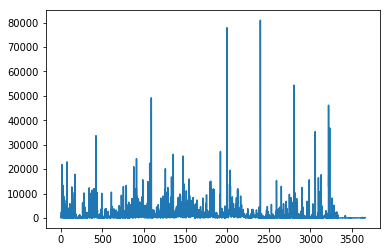

In [21]:
# 상품별 판매수량 분포를 탐색합니다.
print(df.groupby('StockCode')['Quantity'].sum().describe())
plt.plot(df.groupby('StockCode')['Quantity'].sum().values)
plt.show()

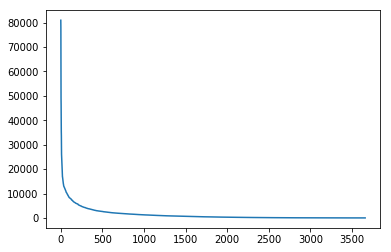

In [22]:
# 분포를 정렬하여 출력합니다.
plt.plot(df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).values)
plt.show()

-----

In [23]:
# 거래별로 발생한 가격에 대해 탐색합니다.
df['amount'] = df['Quantity'] * df['UnitPrice']
df.groupby('InvoiceNo')['amount'].sum().describe()

count     18405.000000
mean        476.378845
std        1678.749892
min           0.380000
25%         157.900000
50%         302.360000
75%         465.700000
max      168469.600000
Name: amount, dtype: float64

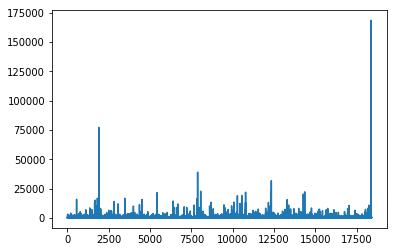

In [24]:
# 거래별로 발생한 가격 분포를 탐색합니다.
plt.plot(df.groupby('InvoiceNo')['amount'].sum().values)
plt.show()

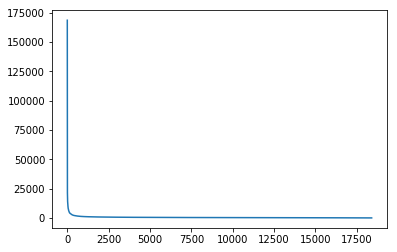

In [25]:
# 분포를 정렬하여 출력합니다.
plt.plot(df.groupby('InvoiceNo')['amount'].sum().sort_values(ascending=False).values)
plt.show()

-----

##### 시계열 기준으로 데이터 분리

In [ ]:
import datetime

# 2011년 11월을 기준으로 하여, 기준 이전과 이후로 데이터를 분리합니다.
df_year_round = df[df['date'] < datetime.date(2011, 11, 1)]
df_year_end = df[df['date'] >= datetime.date(2011, 11, 1)]
print(df_year_round.shape)
print(df_year_end.shape)

(314902, 11)
(81568, 11)


-----

##### 분리된 데이터에서 구매 패턴 탐색 : 재구매, 신규구매 등의 여부

In [ ]:
# 11월 이전 데이터에서 구매했던 상품의 set을 추출합니다.
customer_item_round_set = df_year_round.groupby('CustomerID')['StockCode'].apply(set)
print(customer_item_round_set)

CustomerID
12346                                              {23166}
12347    {23076, 21975, 85167B, 84992, 22772, 21171, 84...
12348    {21967, 21213, 23076, 22952, 84992, 84991, 219...
12350    {20652, 21832, 21171, 22348, 22620, 21864, 790...
12352    {22780, 84050, 23198, 22138, 21754, 22634, 217...
12353                         {37450, 37446, 37449, 22890}
12354    {84997D, 20675, 22668, 23254, 22215, 21922, 22...
12355    {72802C, 22423, 22699, 72802B, 22693, 22890, 2...
12356    {22059, 22131, 21124, 22699, 21198, 22062, 224...
12358    {22059, 48185, 21232, 20679, 22063, 37447, 374...
12359    {22918, 22920, 22411, 22655, 23414, 21754, 229...
12360    {20686, 20677, 23008, 20713, 22571, 22274, 849...
12361    {22328, 22631, 22326, 22382, 20725, 22629, 225...
12362    {20914, 22110, 21918, 22405, 22491, 21829, 206...
12363    {21124, 23234, 21213, 48116, 21122, 22952, 206...
12364    {21124, 22029, 22668, 22620, 21213, 21122, 213...
12365    {22478, 22699, 84884A, 22698, 84987,

In [ ]:
# 11월 이전에 구매했는지 혹은 이후에 구매했는지를 유저별로 기록하기 위한 사전을 정의합니다.
customer_item_dict = {}

# 11월 이전에 구매한 상품은 'old'라고 표기합니다.
for customer_id, stocks in customer_item_round_set.items():
    customer_item_dict[customer_id] = {}
    for stock_code in stocks:
        customer_item_dict[customer_id][stock_code] = 'old'

print(str(customer_item_dict)[:100] + "...")

{'12346': {'23166': 'old'}, '12347': {'23076': 'old', '21975': 'old', '85167B': 'old', '84992': 'old...


In [ ]:
# 11월 이후 데이터에서 구매하는 상품의 set을 추출합니다.
customer_item_end_set = df_year_end.groupby('CustomerID')['StockCode'].apply(set)
print(customer_item_end_set)

CustomerID
12347    {20719, 23552, 21064, 84625A, 21265, 23508, 23...
12349    {20914, 23497, 22131, 22059, 23112, 23460, 231...
12352    {22627, 23367, 22668, 23559, 22635, 23368, 230...
12356                                       {21843, 22423}
12357    {22632, 23196, 22969, 20677, 22025, 23178, 850...
12358       {22059, 20679, 22646, 15056BL, 15056P, 15056N}
12362    {84997D, 23254, 23244, 22816, 23319, 23238, 23...
12364    {22907, 22046, 22706, 16161U, 21499, 21197, 21...
12367    {85227, 22631, 21579, 21576, 16237, 22629, 227...
12374    {46775D, 22734, 22735, 84992, 21788, 22955, 22...
12375                 {20712, 23200, 21930, 85099C, 23203}
12380    {22504, 22467, 22668, 22326, 22628, 22329, 234...
12381    {22423, 22945, 22941, 21976, 23480, 23293, 224...
12384    {85099F, 22632, 22366, 22622, 23480, 21430, 22...
12388    {22340, 22338, 22910, 22576, 22580, 22669, 226...
12391    {23196, 22435, 51014A, 20677, 22210, 23008, 21...
12395    {22029, 22507, 23390, 23487, 21975, 

In [ ]:
# 11월 이전에만 구매한 상품은 'old', 이후에만 구매한 상품은 'new', 모두 구매한 상품은 'both'라고 표기합니다.

for customer_id, stocks in customer_item_end_set.items():
    # 11월 이전 구매기록이 있는 유저인지를 체크합니다.
    if customer_id in customer_item_dict:
        for stock_code in stocks:
            # 구매한 적 있는 상품인지를 체크한 뒤, 상태를 표기합니다.
            if stock_code in customer_item_dict[customer_id]:
                customer_item_dict[customer_id][stock_code] = 'both'
            else:
                customer_item_dict[customer_id][stock_code] = 'new'
    
    # 11월 이전 구매기록이 없는 유저라면 모두 'new'로 표기합니다.
    else:
        customer_item_dict[customer_id] = {}
        for stock_code in stocks:
            customer_item_dict[customer_id][stock_code] = 'new'

print(str(customer_item_dict)[:100] + "...")

{'12346': {'23166': 'old'}, '12347': {'23076': 'old', '21975': 'old', '85167B': 'old', '84992': 'old...


In [ ]:
# 'old', 'new', 'both'를 유저별로 탐색하여 데이터 프레임을 생성합니다.
columns = ['CustomerID', 'old', 'new', 'both']
df_order_info = pd.DataFrame(columns=columns)

# 데이터 프레임을 생성하는 과정입니다.
for customer_id in customer_item_dict:
    old = 0
    new = 0
    both = 0
    
    # 딕셔너리의 상품 상태(old, new, both)를 체크하여 데이터 프레임에 append 할 수 있는 형태로 처리합니다.
    for stock_code in customer_item_dict[customer_id]:
        status = customer_item_dict[customer_id][stock_code]
        if status == 'old':
            old += 1
        elif status == 'new':
            new += 1
        else:
            both += 1
    
    # df_order_info에 데이터를 append합니다.
    row = [customer_id, old, new, both]
    series = pd.Series(row, index=columns)
    df_order_info = df_order_info.append(series, ignore_index=True)

df_order_info.head()

,CustomerID,old,new,both
0,12346,1,0,0
1,12347,92,3,8
2,12348,21,0,0
3,12350,16,0,0
4,12352,43,12,2


In [ ]:
# 데이터 프레임에서 전체 유저 수를 출력합니다.
print(df_order_info.shape[0])

# 데이터 프레임에서 old가 1 이상이면서, new가 1 이상인 유저 수를 출력합니다. 
# 11월 이후에 기존에 구매한적 없는 새로운 상품을 구매한 유저를 의미합니다.
print(df_order_info[(df_order_info['old'] > 0) & (df_order_info['new'] > 0)].shape[0])

# 데이터 프레임에서 both가 1 이상인 유저 수를 출력합니다. 
# 재구매한 상품이 있는 유저 수를 의미합니다.
print(df_order_info[df_order_info['both'] > 0].shape[0])

4334
1446
1426


In [ ]:
# new 피처의 value_counts를 출력하여, 새로운 상품을 얼마나 구매하는지 탐색합니다.
df_order_info['new'].value_counts()

0      2521
1        81
3        73
2        72
8        65
5        64
7        64
4        63
11       61
12       53
6        52
16       50
15       49
9        48
13       48
18       46
14       44
10       43
19       39
17       34
21       33
32       31
26       31
20       29
24       28
22       28
25       26
28       21
27       19
35       19
       ... 
197       1
131       1
130       1
203       1
126       1
124       1
123       1
98        1
121       1
118       1
312       1
63        1
74        1
77        1
82        1
87        1
89        1
90        1
94        1
95        1
97        1
99        1
101       1
102       1
107       1
108       1
113       1
115       1
116       1
391       1
Name: new, Length: 133, dtype: int64

In [ ]:
# 만약 새로운 상품을 구매한다면, 얼마나 많은 종류의 새로운 상품을 구매하는지 탐색합니다.
print(df_order_info['new'].value_counts()[1:].describe())

count    132.000000
mean      13.734848
std       19.130672
min        1.000000
25%        1.000000
50%        5.000000
75%       16.000000
max       81.000000
Name: new, dtype: float64


-----

# <Step2. 예측 분석> : SVD를 활용한 상품 구매 예측

### [피처 엔지니어링]

In [ ]:
# 추천 대상 데이터에 포함되는 유저와 상품의 갯수를 출력합니다.
print(len(df_year_round['CustomerID'].unique()))
print(len(df_year_round['StockCode'].unique()))

3970
3608


-----

##### SVD 모델에 사용할 데이터 : User-Item간의 Rating 데이터 생성 (U-I-R Matrix)

In [ ]:
# Rating 데이터를 생성하기 위한 탐색 : 유저-상품간 구매 횟수를 탐색합니다.
uir_df = df_year_round.groupby(['CustomerID', 'StockCode'])['InvoiceNo'].nunique().reset_index()
uir_df.head()

,CustomerID,StockCode,InvoiceNo
0,12346,23166,1
1,12347,16008,1
2,12347,17021,1
3,12347,20665,1
4,12347,20719,3


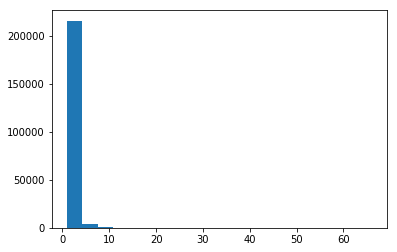

In [ ]:
# Rating(InvoiceNo) 피처의 분포를 탐색합니다.
uir_df['InvoiceNo'].hist(bins=20, grid=False)

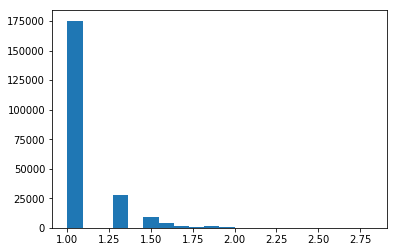

In [ ]:
# Rating(InvoiceNo) 피처를 log normalization 해준 뒤, 다시 분포를 탐색합니다.
uir_df['InvoiceNo'].apply(lambda x: np.log10(x)+1).hist(bins=20, grid=False)

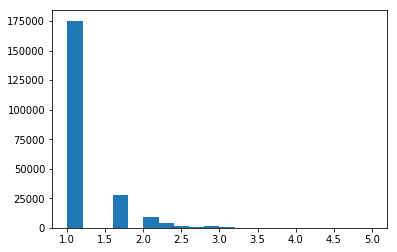

In [ ]:
# 1~5 사이의 점수로 변환합니다.
uir_df['Rating'] = uir_df['InvoiceNo'].apply(lambda x: np.log10(x)+1)
uir_df['Rating'] = ((uir_df['Rating'] - uir_df['Rating'].min()) / 
                    (uir_df['Rating'].max() - uir_df['Rating'].min()) * 4) + 1
uir_df['Rating'].hist(bins=20, grid=False)

-----

### [SVD 모델 학습하기]

In [ ]:
# SVD 모델 학습을 위한 데이터셋을 생성합니다.
uir_df = uir_df[['CustomerID', 'StockCode', 'Rating']]
uir_df.head()

,CustomerID,StockCode,Rating
0,12346,23166,1.000000
1,12347,16008,1.000000
2,12347,17021,1.000000
3,12347,20665,1.000000
4,12347,20719,2.048881


In [ ]:
import time
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다. 대략적인 성능을 알아보기 위해 학습 데이터와 테스트 데이터를 8:2로 분할합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(uir_df[['CustomerID', 'StockCode', 'Rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=200)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

predictions = model.test(test_data)

# 테스트 데이터의 RMSE를 출력하여 모델의 성능을 평가합니다.
print("RMSE of test dataset in SVD model:")
accuracy.rmse(predictions)

training time of model: 32.46 seconds
RMSE of test dataset in SVD model:
RMSE: 0.3413


0.341349430290851

In [ ]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다. 11월 이전 전체를 full trainset으로 활용합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(uir_df[['CustomerID', 'StockCode', 'Rating']], reader)
train_data = data.build_full_trainset()

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=200)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

-----

# <Step3. 예측 평가하기> : 상품 추천 시뮬레이션

### [상품 추천 시뮬레이션]

In [ ]:
"""
11월 이전 데이터에서 유저-상품에 대한 Rating을 기반으로 추천 상품을 선정합니다.

1. 이전에 구매하지 않았던 상품 추천 : anti_build_testset()을 사용합니다.
2. 이전에 구매했던 상품 다시 추천 : build_testset()을 사용합니다.
3. 모든 상품을 대상으로 하여 상품 추천
"""

# 이전에 구매하지 않았던 상품을 예측의 대상으로 선정합니다.
test_data = train_data.build_anti_testset()
target_user_predictions = model.test(test_data)

# 구매 예측 결과를 딕셔너리 형태로 변환합니다.
new_order_prediction_dict = {}
for customer_id, stock_code, _, predicted_rating, _ in target_user_predictions:
    if customer_id in new_order_prediction_dict:
        if stock_code in new_order_prediction_dict[customer_id]:
            pass
        else:
            new_order_prediction_dict[customer_id][stock_code] = predicted_rating
    else:
        new_order_prediction_dict[customer_id] = {}
        new_order_prediction_dict[customer_id][stock_code] = predicted_rating

print(str(new_order_prediction_dict)[:300] + "...")

In [ ]:
# 이전에 구매했었던 상품을 예측의 대상으로 선정합니다.
test_data = train_data.build_testset()
target_user_predictions = model.test(test_data)

# 구매 예측 결과를 딕셔너리 형태로 변환합니다.
reorder_prediction_dict = {}
for customer_id, stock_code, _, predicted_rating, _ in target_user_predictions:
    if customer_id in reorder_prediction_dict:
        if stock_code in reorder_prediction_dict[customer_id]:
            pass
        else:
            reorder_prediction_dict[customer_id][stock_code] = predicted_rating
    else:
        reorder_prediction_dict[customer_id] = {}
        reorder_prediction_dict[customer_id][stock_code] = predicted_rating
        
print(str(reorder_prediction_dict)[:300] + "...")

In [ ]:
# 두 딕셔너리를 하나로 통합합니다.
total_prediction_dict = {}

# new_order_prediction_dict 정보를 새로운 딕셔너리에 저장합니다.
for customer_id in new_order_prediction_dict:
    if customer_id not in total_prediction_dict:
        total_prediction_dict[customer_id] = {}
    for stock_code, predicted_rating in new_order_prediction_dict[customer_id].items():
        if stock_code not in total_prediction_dict[customer_id]:
            total_prediction_dict[customer_id][stock_code] = predicted_rating
            
# reorder_prediction_dict 정보를 새로운 딕셔너리에 저장합니다.
for customer_id in reorder_prediction_dict:
    if customer_id not in total_prediction_dict:
        total_prediction_dict[customer_id] = {}
    for stock_code, predicted_rating in reorder_prediction_dict[customer_id].items():
        if stock_code not in total_prediction_dict[customer_id]:
            total_prediction_dict[customer_id][stock_code] = predicted_rating
            
print(str(total_prediction_dict)[:300] + "...")

In [ ]:
# 11월 이후의 데이터를 테스트 데이터셋으로 사용하기 위한 데이터프레임을 생성합니다.
simulation_test_df = df_year_end.groupby('CustomerID')['StockCode'].apply(set).reset_index()
simulation_test_df.columns = ['CustomerID', 'RealOrdered']
simulation_test_df.head()

In [ ]:
# 이 데이터프레임에 상품 추천 시뮬레이션 결과를 추가하기 위한 함수를 정의합니다.
def add_predicted_stock_set(customer_id, prediction_dict):
    if customer_id in prediction_dict:
        predicted_stock_dict = prediction_dict[customer_id]
        # 예측된 상품의 Rating이 높은 순으로 정렬합니다.
        sorted_stocks = sorted(predicted_stock_dict, key=lambda x : predicted_stock_dict[x], reverse=True)
        return sorted_stocks
    else:
        return None

# 상품 추천 시뮬레이션 결과를 추가합니다.
simulation_test_df['PredictedOrder(New)'] = simulation_test_df['CustomerID']. \
                                            apply(lambda x: add_predicted_stock_set(x, new_order_prediction_dict))
simulation_test_df['PredictedOrder(Reorder)'] = simulation_test_df['CustomerID']. \
                                            apply(lambda x: add_predicted_stock_set(x, reorder_prediction_dict))
simulation_test_df['PredictedOrder(Total)'] = simulation_test_df['CustomerID']. \
                                            apply(lambda x: add_predicted_stock_set(x, total_prediction_dict))
simulation_test_df.head()

-----

### [상품 추천 평가하기]

##### 평가 기준 정의하기

In [ ]:
# 구매 예측의 상위 k개의 recall(재현율)을 평가 기준으로 정의합니다.
def calculate_recall(real_order, predicted_order, k):
    # 만약 추천 대상 상품이 없다면, 11월 이후에 상품을 처음 구매하는 유저입니다.
    if predicted_order is None:
        return None
    
    # SVD 모델에서 현재 유저의 Rating이 높은 상위 k개의 상품을 "구매 할 것으로 예측"합니다.
    predicted = predicted_order[:k]
    true_positive = 0
    for stock_code in predicted:
        if stock_code in real_order:
            true_positive += 1
    
    # 예측한 상품 중, 실제로 유저가 구매한 상품의 비율(recall)을 계산합니다.
    recall = true_positive / len(predicted)
    return recall

# 시뮬레이션 대상 유저에게 상품을 추천해준 결과를 평가합니다.
simulation_test_df['top_k_recall(Reorder)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(Reorder)'], 
                                                                                 5), axis=1)
simulation_test_df['top_k_recall(New)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(New)'], 
                                                                                 5), axis=1)
simulation_test_df['top_k_recall(Total)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(Total)'], 
                                                                                 5), axis=1)

In [ ]:
# 평가 결과를 유저 평균으로 살펴봅니다.
print(simulation_test_df['top_k_recall(Reorder)'].mean())
print(simulation_test_df['top_k_recall(New)'].mean())
print(simulation_test_df['top_k_recall(Total)'].mean())

In [ ]:
# 평가 결과를 점수 기준으로 살펴봅니다.
simulation_test_df['top_k_recall(Reorder)'].value_counts()

In [ ]:
# 평가 결과를 점수 기준으로 살펴봅니다.
simulation_test_df['top_k_recall(New)'].value_counts()

In [ ]:
# 평가 결과를 점수 기준으로 살펴봅니다.
simulation_test_df['top_k_recall(Total)'].value_counts()

In [ ]:
# SVD 모델의 추천기준에 부합하지 않는 유저를 추출합니다.
not_recommended_df = simulation_test_df[simulation_test_df['PredictedOrder(Reorder)'].isnull()]
print(not_recommended_df.shape)
not_recommended_df.head()

-----

##### 시뮬레이션 결과 살펴보기

In [ ]:
# 추천 시뮬레이션 결과를 살펴봅니다.
k = 5
result_df = simulation_test_df[simulation_test_df['PredictedOrder(Reorder)'].notnull()]
result_df['PredictedOrder(Reorder)'] = result_df['PredictedOrder(Reorder)'].\
                                                        apply(lambda x: x[:k])
result_df = result_df[['CustomerID', 'RealOrdered', 
                       'PredictedOrder(Reorder)', 'top_k_recall(Reorder)']]
result_df.columns = [['구매자ID', '실제주문', '5개추천결과', 'Top5추천_주문재현도']]
result_df.sample(5).head()